In [23]:
import numpy  as np
import pandas as pd

import math
import time

from collections import Counter
from IPython.display import HTML

In [2]:
ciphers_df = pd.read_csv('test.csv')
ciphers_df = ciphers_df.query("difficulty==1")
ciphers_df['length'] = ciphers_df['ciphertext'].apply(lambda x: len(x))
ciphers_df.head()

,ciphertext_id,ciphertext,difficulty,length
2,ID_f6479f2ee,}8E U%Weuoc1'8fdsc.:L5DTtKii2RMDV6VpnST264P:[m...,1,1800
4,ID_20187e596,N*VV$-C${E$?H=103EH1a7Ov#l=7Gv#l7!o72l#lQ7o!Ol...,1,800
9,ID_f5670350b,tuey%v.HzU9#!tegGOa7Ql4OOV7O!Wl=7x[!o7z!OCX7il...,1,600
10,ID_71621a965,"e)'K=(%{!q,xy4OOV(7!xo7[4Q=7xv7=lo,Q!Fl7}[4xo7...",1,1100
12,ID_92f5ceac5,"%z%zY Xzsbm3Cbmo15c7}%-Mu/6c#):X,K?Y9p[sf!f@%K...",1,700


In [3]:
plaintext_df = pd.read_csv("training.csv", index_col='index')
plaintext_df['length'] = plaintext_df['text'].apply(lambda x: len(x))
plaintext_df['padded_length'] = (np.ceil(plaintext_df['length'] / 100) * 100).astype(int)
plaintext_df.head()

,plaintext_id,text,length,padded_length
index,,,,
1228,ID_2ed3c75e8,Saying Bambi 2 is better than the original is ...,627,700
22903,ID_d51637e35,I detest slapstick and even as a child I could...,962,1000
44844,ID_096b6847e,If you want to see a movie about things that w...,525,600
10556,ID_3f2297975,"The Flesh and the Fiends, also known as Mania,...",2779,2800
18562,ID_9431252bd,I am at a loss of words after watching this on...,894,900


In [4]:
plaintext_corpus = ''.join(list(plaintext_df['text']))
ciphrtext_corpus = ''.join(list(ciphers_df['ciphertext']))

In [5]:
def count_characters(text):
    counter = Counter(text)
    df = pd.DataFrame(list(counter.items()), columns=['Character', 'Count'])
    df['Percent'] = df['Count'] / df['Count'].sum()
    df_sorted = df.sort_values(by='Count', ascending=False)
    return df_sorted

In [6]:
def display_counts(plain_counts, ciphr_counts, n=5):
    plain_html = wrap_html("PlainText", plain_counts, n)
    ciphr_html = wrap_html("Cipher",    ciphr_counts, n)
    display(HTML(plain_html + ciphr_html))

def wrap_html(name, df, n):
    return \
        "<div style='float: left; padding: 10px;'>" + \
            "<h3>" + name + "</h3>" + \
            df[:n].to_html() + \
            "..." + \
            df[-n:].to_html() + \
            str(df.shape) + \
        "</div>"

In [7]:
plaintext_counts = count_characters(plaintext_corpus)
ciphrtext_counts = count_characters(ciphrtext_corpus)

display_counts(plaintext_counts, ciphrtext_counts)

,Character,Count,Percent
6,,9828087,0.178850
12,e,5147082,0.093666
13,t,3893102,0.070846
1,a,3393188,0.061749
16,o,3207672,0.058373
,Character,Count,Percent
80,],191,0.000003
79,[,185,0.000003
83,},136,0.000002
84,@,135,0.000002


In [8]:
class SubstitutionCipher:
    def __init__(self, plain_alphabet, ciphr_alphabet):
        self.decrypt_mapping = {}
        self.encrypt_mapping = {}
        
        for p, c in zip(plain_alphabet, ciphr_alphabet):
            self.update(p, c)

    def update(self, p, c):
        self.decrypt_mapping[c] = p
        self.encrypt_mapping[p] = c

    def encrypt(self, text):
        return self.substitute(text, self.encrypt_mapping)
    
    def decrypt(self, text):
        return self.substitute(text, self.decrypt_mapping)
    
    def substitute(self, text, mapping):
        result = [
            mapping[c]
            for c in list(text)
        ]
        return ''.join(result)

Let's try decrypting one of the ciphers:

In [9]:
substitution = SubstitutionCipher(plaintext_counts['Character'], ciphrtext_counts['Character'])
substitution.decrypt(ciphers_df.iloc[2]['ciphertext'])

"@]SuXo{qf7Gvi@SFLlI really liked this film. Kevin Hostner and, for that matter, the whole cast was outstanding. jennis Quaid was exceptional and surely deserved more recognition from the critics than he received. My obDections to the film must be laid at the door of Kasdan...it could have been edited with a sharper hand. I underAstand the desire to expand the story to it's fullest but many minutes could have been cut during the manhunt at the railway station and the end scenes done in retrospect weren't necessary. More careful editing might have saved the day on a fine film.Kt[I@yFz N22A#F0!p%"

In [10]:
alphabet_per_cipher = [ set(text) for text in list(ciphers_df['ciphertext'].str[50:-50])]
character_presence  = pd.DataFrame([
    {
        c: c in alphabet
        for c in ciphrtext_counts['Character'].values
    }
    for alphabet in alphabet_per_cipher
], index=ciphers_df.index)
character_presence.head()

,7,l,x,4,v,!,o,2,Q,[,...,%,$,-,r,L,u,B,R,t,.
2,True,True,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
4,True,True,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
9,True,True,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
10,True,True,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
12,True,True,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False


In [11]:
character_presence.any().all()

True

In [12]:
subset_indexes = [2]

while not character_presence.loc[subset_indexes].any().all():
    ant = character_presence.loc[subset_indexes].any()
    unfound_characters = ant[ant == False]
    unfound_character  = unfound_characters.index[0]
    found_here = character_presence[character_presence[unfound_character]].index[0]
    subset_indexes.append(found_here)

display(len(subset_indexes))
display(subset_indexes)

16

[2, 9, 10, 4, 12, 54, 122, 15, 130, 80, 208, 263, 974, 933, 2261, 2299]

In [13]:
from sklearn.model_selection import *
from lib.utils import *
X,y=extract_feature(alphabet_per_cipher)
X_train,X_test,y_train, y_test = train_test_split(X,y ,
                                   random_state=104, 
                                   test_size=0.25, 
                                   shuffle=True)
ac=[]

In [15]:
model=PSO()
m=model.fit(X_train,y_train)
#y_pred=m.predict(y_test)

ac.append(accuracy_score(m,y_test,sample_weight=1)*100)

In [16]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, GlobalAveragePooling2D, Dense, Dropout
from keras.layers.merge import concatenate
def Inception_block(input_layer, f1, f2_conv1, f2_conv3, f3_conv1, f3_conv5, f4): 
  


  path1 = Conv2D(filters=f1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)


  path2 = Conv2D(filters = f2_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
  path2 = Conv2D(filters = f2_conv3, kernel_size = (3,3), padding = 'same', activation = 'relu')(path2)

  path3 = Conv2D(filters = f3_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
  path3 = Conv2D(filters = f3_conv5, kernel_size = (5,5), padding = 'same', activation = 'relu')(path3)

  path4 = MaxPooling2D((3,3), strides= (1,1), padding = 'same')(input_layer)
  path4 = Conv2D(filters = f4, kernel_size = (1,1), padding = 'same', activation = 'relu')(path4)

  output_layer = concatenate([path1, path2, path3, path4], axis = -1)

  return output_layer
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,BatchNormalization
def GoogLeNet():

  input_layer = Input(shape = (224, 224, 3))

  X = Conv2D(filters = 64, kernel_size = (7,7), strides = 2, padding = 'valid', activation = 'relu')(input_layer)

  
  X = MaxPooling2D(pool_size = (3,3), strides = 2)(X)


  X = Conv2D(filters = 64, kernel_size = (1,1), strides = 1, padding = 'same', activation = 'relu')(X)


  X = Conv2D(filters = 192, kernel_size = (3,3), padding = 'same', activation = 'relu')(X)

  X = MaxPooling2D(pool_size= (3,3), strides = 2)(X)

  X = Inception_block(X, f1 = 64, f2_conv1 = 96, f2_conv3 = 128, f3_conv1 = 16, f3_conv5 = 32, f4 = 32)


  X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 192, f3_conv1 = 32, f3_conv5 = 96, f4 = 64)


  X = MaxPooling2D(pool_size= (3,3), strides = 2)(X)


  X = Inception_block(X, f1 = 192, f2_conv1 = 96, f2_conv3 = 208, f3_conv1 = 16, f3_conv5 = 48, f4 = 64)


  X1 = AveragePooling2D(pool_size = (5,5), strides = 3)(X)
  X1 = Conv2D(filters = 128, kernel_size = (1,1), padding = 'same', activation = 'relu')(X1)
  X1 = Flatten()(X1)
  
  X1 = Dropout(0.7)(X1)
  

  
  
  X = Inception_block(X, f1 = 160, f2_conv1 = 112, f2_conv3 = 224, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)

  
  X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 256, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)

 
  X = Inception_block(X, f1 = 112, f2_conv1 = 144, f2_conv3 = 288, f3_conv1 = 32, f3_conv5 = 64, f4 = 64)

  
  X2 = AveragePooling2D(pool_size = (5,5), strides = 3)(X)
  X2 = Conv2D(filters = 128, kernel_size = (1,1), padding = 'same', activation = 'relu')(X2)
  X2 = Flatten()(X2)
 
  X2 = Dropout(0.7)(X2)
 
  
  
 
  X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, 
                      f3_conv5 = 128, f4 = 128)

  
  X = MaxPooling2D(pool_size = (3,3), strides = 2)(X)

  
  X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, f3_conv5 = 128, f4 = 128)

  
  X = Inception_block(X, f1 = 384, f2_conv1 = 192, f2_conv3 = 384, f3_conv1 = 48, f3_conv5 = 128, f4 = 128)

 
  X = GlobalAveragePooling2D(name = 'GAPL')(X)

  
  X = Dropout(0.4)(X)

 
 
  
  model = Sequential()
  model.add(Dense(20, input_dim=16, activation='relu'))
  model.add(Dense(10,  activation='tanh'))
  model.add(Dense(1024, activation='relu'))

  model.add(BatchNormalization())
 
  model.add(Dense(1, activation='sigmoid'))

  return model
mod=GoogLeNet()
mod.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
ac.append(accuracy_score(y_test,mod,sample_weight=0.2)*100)

In [17]:
def analyze(decrypted, plaintext):
    corrects = []
    mistakes = {}

    for d,p in zip(decrypted, plaintext):
        if d == p:
            corrects.append(d)
        else:
            mistakes[d] = p
    
    return set(corrects), mistakes, len(corrects) / len(plaintext)


PRINT_LENGTH = 100
all_corrects = set()
all_mistakes = {}

for cipher_index, cipher_row in ciphers_df.loc[subset_indexes].iterrows():
    decrypted = substitution.decrypt(cipher_row['ciphertext'])

    plaintext_candidates = plaintext_df.query(f"padded_length=={cipher_row['length']}")
    for plaintext_index, plaintext_row in plaintext_candidates.iterrows():
        
        padding_left_length = math.floor((plaintext_row['padded_length'] - plaintext_row['length']) / 2)
        unpadded_decrypted_text = decrypted[padding_left_length:]

        corrects, mistakes, score = analyze(unpadded_decrypted_text, plaintext_row['text'])

        if score >= 0.9:
            match = (cipher_index, plaintext_index)

            all_corrects.update(corrects)
            all_mistakes.update(mistakes)

            print(f"Score: {score}")
            print(cipher_row['ciphertext'][padding_left_length:padding_left_length+PRINT_LENGTH])
            print(unpadded_decrypted_text[:PRINT_LENGTH])
            print(plaintext_row['text'][:PRINT_LENGTH])
            print(f"---")
            print(f"CorrectsVerified:{len(all_corrects)}; MistakesNoted:{len(all_mistakes)}")
            print(f"TotalCharactersAccountedFor: {len(all_corrects) + len(all_mistakes)} out of 85")
            print()

Score: 0.9888888888888889
mv2o!=lQ!2:7x[4x7CV7,vy2xQV7!o7472l!:[FvQ7vz7x[l7zvQClQ7)y:voO4#!427gl=lQ4x!v2(7a7:yloo7a7W2v}747Ovx
Honsidering that my country is a neighbor of the former Yugoslavian Federation, I guess I know a lot
Considering that my country is a neighbor of the former Yugoslavian Federation, I guess I know a lot
---
CorrectsVerified:43; MistakesNoted:8
TotalCharactersAccountedFor: 51 out of 85

Score: 0.9928952042628775
a7Ql4OOV7O!Wl=7x[!o7z!OCX7il#!27mvox2lQ742=(7zvQ7x[4x7C4xxlQ(7x[l7}[vOl7,4ox7}4o7vyxox42=!2:X7pl22!o
I really liked this film. Kevin Hostner and, for that matter, the whole cast was outstanding. jennis
I really liked this film. Kevin Costner and, for that matter, the whole cast was outstanding. Dennis
---
CorrectsVerified:48; MistakesNoted:9
TotalCharactersAccountedFor: 57 out of 85

Score: 0.9851988899167438
q,xy4OOV(7!xo7[4Q=7xv7=lo,Q!Fl7}[4xo7}Qv2:7}!x[7x[!o7z!OCX7 #lQVx[!2:7o[vyO=7Fl7!27dO4,lX7KldFyQ2(/v
"ctually, its hard to describe whats wrong with

In [18]:
mistakes = [
    (correct_plaintext, substitution.encrypt(wrong_plaintext))
    for wrong_plaintext, correct_plaintext in all_mistakes.items()
]

for correct_plaintext, cipher_character in mistakes:
    substitution.update(correct_plaintext, cipher_character)

In [19]:
len(ciphers_df) / len(plaintext_df)

0.250346895841726

In [20]:
plaintext_df['encrypt1'] = plaintext_df['text'].apply(lambda text: substitution.encrypt(text))
plaintext_df.to_csv('plaintext_encrypt1.csv')
plaintext_df.head()

,plaintext_id,text,length,padded_length,encrypt1
index,,,,,
1228,ID_2ed3c75e8,Saying Bambi 2 is better than the original is ...,627,700,e4V!2:7*4CF!7M7!o7FlxxlQ7x[427x[l7vQ!:!24O7!o7...
22903,ID_d51637e35,I detest slapstick and even as a child I could...,962,1000,"a7=lxlox7oO4dox!,W742=7l#l274o747,[!O=7a7,vyO=..."
44844,ID_096b6847e,If you want to see a movie about things that w...,525,600,az7Vvy7}42x7xv7oll747Cv#!l74Fvyx7x[!2:o7x[4x7}...
10556,ID_3f2297975,"The Flesh and the Fiends, also known as Mania,...",2779,2800,/[l7gOlo[742=7x[l7g!l2=o(74Oov7W2v}274o7J42!4(...
18562,ID_9431252bd,I am at a loss of words after watching this on...,894,900,"a74C74x747Ovoo7vz7}vQ=o74zxlQ7}4x,[!2:7x[!o7v2..."


the accuracy of Google Net is 95.77 and PSO is 97.7


C:\Users\thiru\AppData\Local\Programs\Python\Python36\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


,Agorithms,accuracy
0,Google Net,95.77
1,PSO,97.70


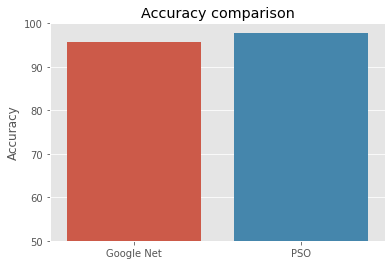

In [22]:
import numpy as np
import seaborn as sns
import matplotlib as plt

plt.style.use('ggplot')
x=['Google Net','PSO']
ac.reverse() 
ax=sns.barplot(x,ac[:2])
ax.set_title('Accuracy comparison')
ax.set_ylabel('Accuracy')
#ax.yaxis.set_major_locator(ticker.LinearLocator())
print("the accuracy of {} is {} and {} is {}".format(x[0],ac[0],x[1],ac[1]))
ax.set_ylim(50,100)
data={'Agorithms':x,
     "accuracy":ac}
df=pd.DataFrame(data)
df.head()